In [84]:
!pip install seaborn

You should consider upgrading via the '/opt/anaconda3/envs/env/bin/python -m pip install --upgrade pip' command.


In [1]:
import requests 
from pprint import pprint as pp
import pandas as pd 
from tqdm import tqdm 
from datetime import date 
import seaborn as sns
import matplotlib.pyplot as plt

import os
import numpy as np

from pymongo import MongoClient
from IPython.display import clear_output 

%matplotlib inline

[tender Schema](https://gist.github.com/imaginal/bf19e659b34b6acd7ee002f6b88dbf81)

[interesting example, lots, multiple awards ect](https://public.api.openprocurement.org/api/2.5/tenders/98d54c150056474fbedb5420f8aad0d9)

## Download data from API

Depricated: Use scrapy

In [3]:
import datetime


datetime.datetime.fromisoformat('2021-10-01') - datetime.timedelta(days=30)

datetime.datetime(2021, 9, 1, 0, 0)

In [4]:
from urllib.parse import urlparse, parse_qsl, urljoin
import datetime

tz = datetime.timezone(datetime.timedelta(seconds=10800))
start_date = datetime.datetime(2021,1,1,tzinfo=tz)
end_date = datetime.datetime(2021,10,1,tzinfo=tz)

api_path = "https://public.api.openprocurement.org/api/2.5/"

next_page_url = urljoin(api_path,f"tenders?offset={start_date.isoformat()}")
offset_date = start_date

tender_ids = []

while offset_date<end_date:

    clear_output()
    print(f'Date {offset_date} tender ids {len(tender_ids) }')

    page = requests.get(next_page_url).json()
    
    # new next page
    next_page_url = page["next_page"]["uri"]    

    tender_ids += [tender["id"] for tender in page["data"]]

    qs = dict(
        parse_qsl(
            urlparse(next_page_url).query
            )
        )

    # to compare with end date
    offset_date = datetime.datetime.fromisoformat(qs['offset'])

# unique
tender_ids = list(set(tender_ids))

In [ ]:
with open('./scraper/tender_ids.txt', 'w') as f:
    f.writelines(s + '\n' for s in tender_ids)

In [163]:
with open('./scraper/tender_ids.txt', 'r') as f:
    tender_ids = [line.strip() for line in f.readlines()]

len(tender_ids)

476400

In [19]:
client = MongoClient()
db = client['prozorro']
tenders_collection = db['tenders']

# USE SPIDER - work faster and has outothrottle mechanism
def get_tender(tender_id):
    response = requests.get(
        urljoin(api_path+'tenders/', tender_id)
    ).json()

    tender = response["data"]

    del tender['id']
    
    update_info = tenders_collection.update({'_id':tender_id}, tender, upsert=True)
    return update_info

# slow
for tender_id in tqdm(tender_ids):
    
    get_tender(tender_id)


In [172]:
import concurrent.futures

# faster

# with concurrent.futures.ThreadPoolExecutor() as executor:
#     for tender_id, prime in zip(tender_ids, executor.map(get_tender, tender_ids)):
#         clear_output()
#         print('Tender %s is acknowledged: %s' % (tender_id, prime))

## Get data from local Mongo DB

### Read mongo

In [2]:
client = MongoClient()
db = client['prozorro']
tenders_collection = db['tenders']

In [3]:
# https://docs.mongodb.com/manual/tutorial/project-fields-from-query-results/#return-specific-fields-in-embedded-documents

def read_mongo(db, collection, query={}, fields=None, id_to_index=False, limit: int = 0):
    """ Read from Mongo and Store into DataFrame """

    # Make a query to the specific DB and Collection
    
    # filter fields
    _fields = None
    if fields is not None:
        _fields = fields if isinstance(fields, dict) else {field:1 for field in fields}

    cursor = db[collection].find(query, _fields)

    if limit:
        cursor.limit(limit)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor)).rename(columns={'_id':'id'})

    # Delete the _id
    if id_to_index:
        df.set_index('id')

    return df

# You can put filter here or later in pandas dataset
# equvalent to
# SELECT fields
#   FROM collection
#   WHERE query
# df = read_mongo(db, collection='tenders', query={'status':'complete'}, fields=['status', 'items'])


In [13]:
df = read_mongo(db, collection='tenders', query={'status':'complete'}, fields=['status', 'awards', 'bids'], limit=10000)

### Nested collection to separate dataframe

In [14]:
# subcollection to df
items = []

for row in df.itertuples():
    for itm in row.items:
        items.append({
            **itm,
            'tender_id':row.id})
        
items_df = pd.DataFrame(items)
del items

In [15]:
items_df['classification_scheme'] = items_df.classification.apply(lambda x: x['scheme'])
items_df['classification_code'] = items_df.classification.apply(lambda x: x.get('id',None))
items_df['classification_description'] = items_df.classification.apply(lambda x: x.get('description',None))


In [16]:
items_df.head()

,id,description,quantity,classification,unit,deliveryDate,deliveryAddress,tender_id,additionalClassifications,deliveryLocation,relatedLot,description_en,classification_scheme,classification_code,classification_description
0,9a63616c7ce84a26a8743d974eee647e,Електрична енергія з оплатою розподілу через п...,194000.0,"{'description': 'Електрична енергія', 'scheme'...","{'name': 'кВт⋅год', 'code': 'KWH'}","{'startDate': '2021-01-01T00:00:00+02:00', 'en...","{'streetAddress': 'Курчатова 11', 'locality': ...",fb1e3124a4084c619c28c9a01c8a7bad,NaN,NaN,NaN,NaN,ДК021,09310000-5,Електрична енергія
1,e9309354b5994fca8962019ad36c0856,Електрична енергія з оплатою розподілу через п...,435000.0,"{'description': 'Електрична енергія', 'scheme'...","{'name': 'кВт⋅год', 'code': 'KWH'}","{'startDate': '2021-01-01T00:00:00+02:00', 'en...","{'streetAddress': 'Геофізиків, 10', 'locality'...",911611564c4240e7b77ee5a5a5f7f05d,NaN,NaN,NaN,NaN,ДК021,09310000-5,Електрична енергія
2,131afb8d63b4bc56c9adcbb1872b2249,бюлетні,326.0,"{'description': 'Бланки', 'scheme': 'ДК021', '...","{'name': 'шт', 'code': 'H87', 'value': {'amoun...","{'startDate': '2020-12-29T10:01:46+02:00', 'en...","{'streetAddress': 'вул. Завгороднього, 9', 'lo...",dc220e19c3b042078f6c25867e4e5550,NaN,NaN,NaN,NaN,ДК021,22820000-4,Бланки
3,5d9d6faedfed69264968b4ac1676bbba,протоколи,20.0,"{'description': 'Бланки', 'scheme': 'ДК021', '...","{'name': 'шт', 'code': 'H87', 'value': {'amoun...","{'startDate': '2020-12-29T10:01:46+02:00', 'en...","{'streetAddress': 'вул. Завгороднього, 9', 'lo...",dc220e19c3b042078f6c25867e4e5550,NaN,NaN,NaN,NaN,ДК021,22820000-4,Бланки
4,af6856d348cf4ca694924fbbf8b74edb,"Експертиза робочого проекту ""Капітальний ремон...",1.0,"{'description': 'Експертні послуги', 'scheme':...","{'name': 'послуга', 'code': 'E48'}",{'endDate': '2020-12-31T00:00:00+02:00'},"{'streetAddress': '1 Травня ,7а', 'locality': ...",ef81bc6bc5044f4e91df4dc288f9ac4b,NaN,NaN,NaN,NaN,ДК021,71319000-7,Експертні послуги


## DK021 normalization 

In [22]:
from utils.dk021 import DK021

classifier = DK021.load('./data/dk021.csv')

items_df['code_l1'] = items_df.classification_code.apply(lambda code: classifier.get_level_category(code=code, level=1).description)

In [23]:
items_df['code_l1'].value_counts().head(10)

Продукти харчування, напої, тютюн та супутня продукція                                                                                        2203
Медичне обладнання, фармацевтична продукція та засоби особистої гігієни                                                                       2100
Нафтопродукти, паливо, електроенергія та інші джерела енергії                                                                                 1685
Конструкції та конструкційні матеріали; допоміжна будівельна продукція (крім електроапаратури)                                                1066
Комунальні послуги                                                                                                                             851
Послуги з ремонту і технічного обслуговування                                                                                                  846
Сільськогосподарська, фермерська продукція, продукція рибальства, лісівництва та супутня продукція                    

## n bids to relative economy 

In [4]:
df = read_mongo(db, collection='tenders', query={'status':'complete', 'submissionMethod':'electronicAuction'}, fields=['status', 'awards', 'value', 'numberOfBids'])

In [5]:
df['award_amount'] = df.awards.apply(lambda awards: sum([award['value']['amount'] for award in awards]))
df['value_amount'] = df.value.apply(lambda value: value['amount'])
df['economy'] = 100*(df['value_amount'] - df['award_amount'])/df['value_amount']
df['currency'] = df.value.apply(lambda value: value['currency'])
df.shape

(278072, 8)

In [6]:
df[['id','numberOfBids','value_amount','award_amount','economy']].head(20)

,id,numberOfBids,value_amount,award_amount,economy
0,22cb88ebaac14ab2ac048cec40909ba6,4,1086180.00,591366.00,45.555433
1,d7ac4dfc5e394932b13f0ba7f50c7f47,2,4125000.00,4000000.00,3.030303
2,221a19eb687242e29ee270b156167e04,3,2368800.00,2723000.00,-14.952719
3,621e686f458648558b212c9d50d6b176,2,999600.00,976668.00,2.294118
4,f07499820f034dcd930138c290bcc54d,2,999600.00,934920.00,6.470588
5,a207915c730f4235b1995402c1cf39d0,3,892800.00,720000.00,19.354839
6,90d346e634154be78296a9856ac7f1a3,1,63700.00,44249.45,30.534615
7,5f66e464c0d94702be1219e1efd20f76,2,90000.00,83000.00,7.777778
8,a6e01d54b36a47cea22f52d5db0daa41,2,185450.00,343940.00,-85.462389
9,3efacc853bd64ddba49a6b94e84f442d,1,199998.76,199279.34,0.359712


In [15]:
# how is it possible to make bid > than value
sum(df['economy']>=0)

234741

In [30]:
# for plot
df_cleaned = df[df['economy']>=0]
df_cleaned = df_cleaned[df_cleaned.currency=="UAH"]

In [31]:
print(len(df[df['numberOfBids']==1])/len(df))
print(len(df_cleaned[df_cleaned['numberOfBids']==1])/len(df_cleaned))

0.3891689922034581
0.45866875769753634


In [32]:
df_cleaned['economy_value'] = df_cleaned['value_amount'] - df_cleaned['award_amount']
df_cleaned['economy_theoretical_value'] = df_cleaned['value_amount']*0.35

In [33]:
sum(df_cleaned['economy_theoretical_value']-df_cleaned['economy_value'])

137771780103.40866

In [ ]:
137 771 780 103

In [65]:
df_grouped = df_cleaned.groupby(by='numberOfBids').agg({'economy':'mean', 'id':'count'}).reset_index()
df_grouped.head(10)

,numberOfBids,economy,id
0,1,4.800473,107679
1,2,10.860571,81188
2,3,23.626125,24162
3,4,28.324201,10795
4,5,32.766239,4991
5,6,34.591814,2556
6,7,37.504290,1382
7,8,35.692054,816
8,9,38.987253,432
9,10,41.161189,271


In [68]:
# outliers
df_grouped = df_grouped[df_grouped.id>10]

In [84]:
df_grouped['count_log'] = np.log2(df_grouped.id).astype(int)*15

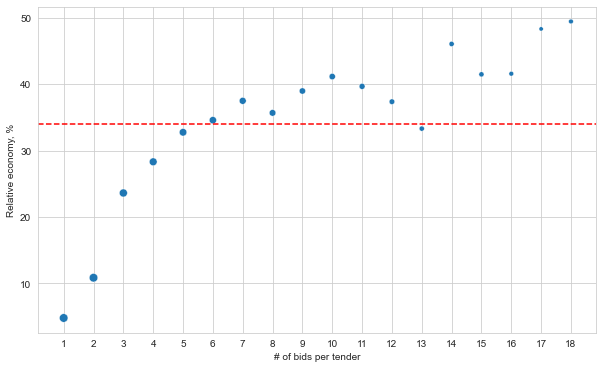

In [111]:
fig, ax = plt.subplots(figsize=(10,6))
ax.axhline(34, ls='--', color='red')
ax = sns.scatterplot(ax=ax, data=df_grouped, x="numberOfBids", palette="deep", y="economy", size='count_log', legend=False)
ax.set_xlabel('# of bids per tender')
ax.set_ylabel('Relative economy, %')
ax.set_xticks(df_grouped.numberOfBids.to_list());

# Relation between the received offers of bidders and the underbid Ukraine

In [109]:
df_grouped.economy.mean()

34.75799198929757

## geocoding

In [35]:
df = read_mongo(db, collection='tenders', query={'status':'complete'}, fields=['status', 'procuringEntity', 'bids'], limit=50000)

In [2]:
# geocode buyer

from utils.geolocation import CachedGeolocator, location_fixer # Проблема 6 Некоректні регіони + місто
geolocator = CachedGeolocator(cache_dir='./data/geo_cache', verbose=False)

In [37]:
not_located = []
located = []

def address_to_location(address):
    address_info = [
        location_fixer(address['locality']) if 'locality' in address else '', 
        address.get('region', '').lower().strip(), 
        address.get('countryName', '').lower().strip()
    ]

    query = ' '.join(address_info)

    # kyiv fix 
    query = query.replace('м. ', '')
    query = query.replace('місто ', '')
    
    point = geolocator(query)
    # for statictics
    if point is None:
        not_located.append(query)
    return point


# df['location'] = df.procuringEntity.apply(lambda pe: address_to_location(pe['address']))

for row in df.itertuples():

    address = row.procuringEntity['address']

    located.append(address_to_location(address))
    

!!!Not found маріуполь старий крим донецька область україна
!!!Not found маріуполь старий крим донецька область україна
!!!Not found малижено харківська область україна
!!!Not found селеще божківське полтавська область україна
!!!Not found чернівц чернівецька область україна
!!!Not found сіло мигія миколаївська область україна
!!!Not found мімто борислав львівська область україна
!!!Not found кам'янець-подільский хмельницька область україна
!!!Not found херсон антонівка херсонська область україна
!!!Not found камьянське дніпропетровська область україна
!!!Not found сhernigiv чернігівська область україна
!!!Not found чернівц чернівецька область україна
!!!Not found херсон антонівка херсонська область україна
!!!Not found чернівц чернівецька область україна
!!!Not found черноморськ одеська область україна
!!!Not found місьго типу дубляни львівська область україна
!!!Not found новаушиця хмельницька область україна
!!!Not found камянка черкаська область україна
!!!Not found с-ще інженерне 

In [30]:
print(f'Errors {len([lctd for lctd in located if lctd is None])}')
print(f'located {len(located)}')
geolocator.close()

Errors 110
located 20000


In [39]:
print(f'Not found in {100*250/50000} %')

Not found in 0.5 %
